# 회귀분석

## 검증하고자 하는 것 : 맛집 프로그램별 SNS채널(네이버 블로그)에 미치는 영향력

### 분석계획 
### 1. 독립변수에 방송 프로그램 외 변수들을 추가하면서 R^2가 높아지는지 확인 & R^2가 가장 높은 회귀식 도출
### *2. 방송 프로그램별 회귀식을 만들어 포스팅 증가에 가장 영향을 미치는 요인 찾아보기*
### 3. 2017년 데이터(train set)로 회귀식을 만든 후, 2018년 데이터(test set)로 예측해보고 정확도 확인

In [1]:
import pandas as pd
import numpy as np

In [2]:
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from scipy import stats
from statsmodels.compat import lzip
import statsmodels
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('raw_data/reg.csv')

In [6]:
df.head()

,식당,방송,방영전,방영후,증가,서울,방영월
0,136생고기,생생정보,4,45,41,0,3
1,3일한우국밥,생생정보,35,51,16,1,3
2,가람떡갈비,맛있는녀석들,21,50,29,1,1
3,가마솥 족발,생생정보,31,106,75,0,3
4,가마솥손두부,생생정보,11,45,34,1,4


In [8]:
#봄(3-5월), 여름(6-8월), 가을(9-11월), 겨울(12-2월)
df.loc[(df['방영월']>2)&(df['방영월']<6), '계절'] = '봄'
df.loc[(df['방영월']>5)&(df['방영월']<9), '계절'] = '여름'
df.loc[(df['방영월']>8)&(df['방영월']<12), '계절'] = '가을'
df.loc[(df['방영월']<3)|(df['방영월']==12), '계절'] = '겨울'

In [14]:
df['서울'] = df['서울'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317 entries, 0 to 316
Data columns (total 8 columns):
식당     317 non-null object
방송     317 non-null object
방영전    317 non-null int64
방영후    317 non-null int64
증가     317 non-null int64
서울     317 non-null category
방영월    317 non-null int64
계절     317 non-null object
dtypes: category(1), int64(4), object(3)
memory usage: 17.8+ KB


In [9]:
df.head()

,식당,방송,방영전,방영후,증가,서울,방영월,계절
0,136생고기,생생정보,4,45,41,0,3,봄
1,3일한우국밥,생생정보,35,51,16,1,3,봄
2,가람떡갈비,맛있는녀석들,21,50,29,1,1,겨울
3,가마솥 족발,생생정보,31,106,75,0,3,봄
4,가마솥손두부,생생정보,11,45,34,1,4,봄


In [15]:
sangsang = df.loc[df['방송']=='생생정보'].reset_index().drop(['index'], axis=1)
sangsang.tail()

,식당,방송,방영전,방영후,증가,서울,방영월,계절
106,행복한 콩박사,생생정보,4,23,19,0,2,겨울
107,현래장,생생정보,20,39,19,1,6,여름
108,현호네 매운갈비찜,생생정보,4,25,21,0,3,봄
109,화진포막국수,생생정보,11,42,31,1,2,겨울
110,후라토 식당,생생정보,36,61,25,1,2,겨울


In [16]:
suyo = df.loc[df['방송']=='수요미식회'].reset_index().drop(['index'], axis=1)
suyo.tail()

,식당,방송,방영전,방영후,증가,서울,방영월,계절
100,평양집,수요미식회,47,189,142,1,1,겨울
101,포담,수요미식회,13,109,96,1,2,겨울
102,함흥에겨울냉면,수요미식회,12,133,121,1,7,여름
103,해남집,수요미식회,1,53,52,1,2,겨울
104,화선횟집,수요미식회,9,52,43,0,8,여름


In [17]:
mashit = df.loc[df['방송']=='맛있는녀석들'].reset_index().drop(['index'], axis=1)
mashit.tail()

,식당,방송,방영전,방영후,증가,서울,방영월,계절
96,한옥집,맛있는녀석들,51,80,29,1,7,여름
97,현대북어찜,맛있는녀석들,8,27,19,1,3,봄
98,홍어랑 민어랑,맛있는녀석들,0,16,16,1,6,여름
99,화수목,맛있는녀석들,32,41,9,0,2,겨울
100,황금복국,맛있는녀석들,6,29,23,1,8,여름


## X : 방영전 포스팅 수, 서울(서울:1, 서울 외 지역:0), 계절(봄, 여름, 가을, 겨울)

## Y : 방영 후 포스팅 증감 수(생생정보통, 수요미식회, 맛있는 녀석들)

## 데이터 전처리 : 더미변수 만들기

In [18]:
def dummy_data(data, columns):
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix = column)], axis=1)
        data = data.drop(column, axis=1)
    return data

In [20]:
dummy_columns = ['서울', '계절']

reg_sang = dummy_data(sangsang, dummy_columns)
reg_sang.head()

reg_suyo = dummy_data(suyo, dummy_columns)
reg_mot = dummy_data(mashit, dummy_columns)

In [21]:
reg_sang.columns

Index(['식당', '방송', '방영전', '방영후', '증가', '방영월', '서울_0', '서울_1', '계절_가을', '계절_겨울',
       '계절_봄', '계절_여름'],
      dtype='object')

In [22]:
def drop_not_concerned(data, columns):
    return data.drop(columns, axis=1)

not_concerned_columns = ["방영후", "방영월", "서울_0", "계절_봄"]

reg_sang = drop_not_concerned(reg_sang, not_concerned_columns)
reg_suyo = drop_not_concerned(reg_suyo, not_concerned_columns)
reg_mot = drop_not_concerned(reg_mot, not_concerned_columns)

In [24]:
reg_sang.head()

,식당,방송,방영전,증가,서울_1,계절_가을,계절_겨울,계절_여름
0,136생고기,생생정보,4,41,0,0,0,0
1,3일한우국밥,생생정보,35,16,1,0,0,0
2,가마솥 족발,생생정보,31,75,0,0,0,0
3,가마솥손두부,생생정보,11,34,1,0,0,0
4,갈비구락부,생생정보,36,10,0,1,0,0


## 생생정보통 회귀분석

### 모형 : 증가(y) ~ 방영전(x1) + 서울_1(x2) + 계절_여름(x3) + 계절_가을(x4) + 계절_겨울(x5)

In [38]:
model_sang = smf.ols("증가 ~ 방영전 + 서울_1 + 계절_여름 + 계절_가을 + 계절_겨울",  data=reg_sang).fit(cov_type='HC3')

## 1. 가정

### 1) 정규성

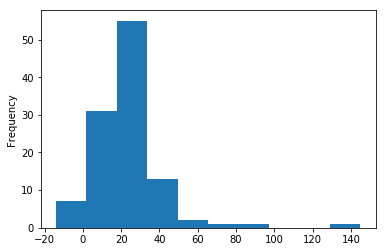

In [26]:
reg_sang['증가'].plot(kind='hist')

왼쪽으로 치우쳐 있어 변환이 필요해 보이나, 음수 값이 있어서 log변환이나 box-cox변환을 할 수 없음

Q-Q plot을 보자

Text(0.5,1,'SANGSANG Model Residuals Q-Q Plot')

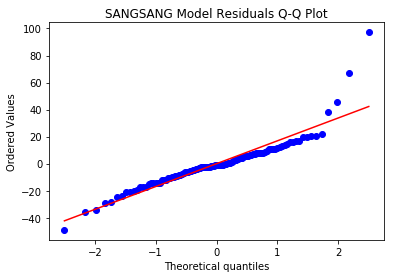

In [28]:
stats.probplot(model_sang.resid, dist="norm", plot= plt)
plt.title("SANGSANG Model Residuals Q-Q Plot")

엄밀히 정규성을 따른다고 말하기 어렵지만, 데이터 갯수(110)가 크니 중심극한정리(CLT)에 의해 정규분포를 따른다고 가정하겠음

### 2) 등분산

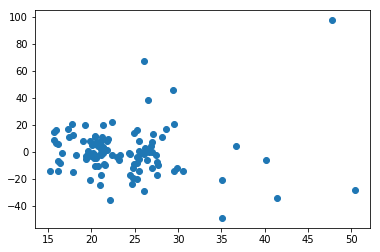

In [32]:
resid = model_sang.resid
plt.scatter(model_sang.predict(), resid)

In [34]:
name = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
test = sms.het_breuschpagan(model_sang.resid, model_sang.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 31.154615274950665),
 ('p-value', 8.731270432195287e-06),
 ('f-value', 8.19392283006574),
 ('f p-value', 1.4577522164084115e-06)]

p-value < 0.05 이므로 등분산 가정도 만족을 안 한다..

### 3) 오차의 독립성

In [35]:
statsmodels.stats.stattools.durbin_watson(model_sang.resid)

1.8893790316069845

2에 가까울수록 독립성 가정이 만족하는데, 2에 가까우니 독립성 가정도 만족

### 4) 다중공선성

In [36]:
reg_sang.corr()

,방영전,증가,서울_1,계절_가을,계절_겨울,계절_여름
방영전,1.000000,0.257322,0.010664,-0.007737,-0.056887,-0.078714
증가,0.257322,1.000000,0.021697,-0.140428,-0.032156,-0.038590
서울_1,0.010664,0.021697,1.000000,-0.010467,0.028020,-0.048357
계절_가을,-0.007737,-0.140428,-0.010467,1.000000,-0.373544,-0.221268
계절_겨울,-0.056887,-0.032156,0.028020,-0.373544,1.000000,-0.284327
계절_여름,-0.078714,-0.038590,-0.048357,-0.221268,-0.284327,1.000000


변수들 사이에 강한 상관관계가 보이지 않으므로 다중공선성 문제는 없다고 봐도 무방함

## 2. 회귀분석 결과

In [39]:
#model_sang = smf.ols("증가 ~ 방영전 + 서울_1 + 계절_여름 + 계절_가을 + 계절_겨울",  data=reg_sang).fit(cov_type='HC0')
model_sang.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     증가   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                    0.9487
Date:                Thu, 30 Aug 2018   Prob (F-statistic):              0.453
Time:                        16:22:39   Log-Likelihood:                -478.29
No. Observations:                 111   AIC:                             968.6
Df Residuals:                     105   BIC:                             984.8
Df Model:                           5                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.6807      3.556      6.941      0.000      17.711      31.650
방영전            0.1520      0.177      0.859      0.390      -0.195       0.499
서울_1           0.6133      3.625      0.169      0.866      -6.493       7.719
계절_여름         -5.4100      4.791     -1.129      0.259     -14.800       3.980
계절_가을         -9.4034      4.963     -1.895      0.058     -19.130       0.323
계절_겨울         -5.0543      4.967     -1.018      0.309     -14.790       4.682
==============================================================================
Omnibus:                       60.332   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              359.592
Skew:                           1.684   Prob(JB):                     8.23e-79
Kurtosis:                      11.149   Cond. No.                         157.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

**F-statstic의 p-value > 0.05 이므로 회귀모형 자체가 유의하지 않음**

**생생정보통의 경우, 방영 전 포스팅 갯수, 서울 여부, 계절 변수는 방영된 후 포스팅 갯수의 증감에 통계적으로 영향력이 없음**

**생생정보통은 특색이 없는 거 같다...**

## 수요미식회 회귀분석

### 모형 : 증가(y) ~ 방영전(x1) + 서울_1(x2) + 계절_여름(x3) + 계절_가을(x4) + 계절_겨울(x5)

In [40]:
model_suyo = smf.ols("증가 ~ 방영전 + 서울_1 + 계절_여름 + 계절_가을 + 계절_겨울",  data=reg_suyo).fit(cov_type='HC3')

## 1. 가정

### 1) 정규성

Text(0.5,1,'SUYO Model Residuals Q-Q Plot')

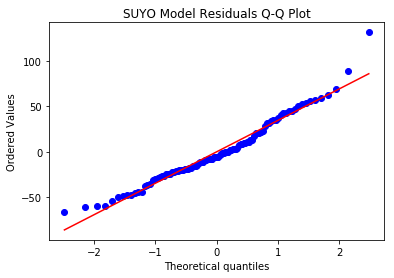

In [41]:
stats.probplot(model_suyo.resid, dist="norm", plot= plt)
plt.title("SUYO Model Residuals Q-Q Plot")

정규성을 따른다고 볼 수 있음

### 2) 등분산

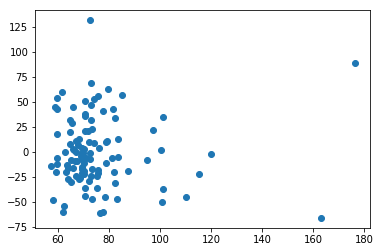

In [42]:
resid = model_suyo.resid
plt.scatter(model_suyo.predict(), resid)

In [43]:
name = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
test = sms.het_breuschpagan(model_suyo.resid, model_suyo.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 10.523989729472273),
 ('p-value', 0.06167878534949145),
 ('f-value', 2.205586328707983),
 ('f p-value', 0.059640818314463495)]

p-value > 0.05 이므로 등분산 가정도 만족

### 3) 오차의 독립성

In [44]:
statsmodels.stats.stattools.durbin_watson(model_suyo.resid)

1.8269518592692542

2에 가까울수록 독립성 가정이 만족하는데, 2에 가까우니 독립성 가정도 만족

## 2. 회귀분석 결과

In [45]:
#model_suyo = smf.ols("증가 ~ 방영전 + 서울_1 + 계절_여름 + 계절_가을 + 계절_겨울",  data=reg_suyo).fit(cov_type='HC3')
model_suyo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     증가   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                    0.9410
Date:                Thu, 30 Aug 2018   Prob (F-statistic):              0.458
Time:                        16:25:15   Log-Likelihood:                -520.95
No. Observations:                 105   AIC:                             1054.
Df Residuals:                      99   BIC:                             1070.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     64.2236      9.298      6.907      0.000      46.000      82.447
방영전            0.3489      0.176      1.982      0.048       0.004       0.694
서울_1           3.5797      8.655      0.414      0.679     -13.383      20.543
계절_여름        -10.2625     12.178     -0.843      0.399     -34.131      13.606
계절_가을         -5.8806      8.993     -0.654      0.513     -23.506      11.745
계절_겨울          1.0752      9.957      0.108      0.914     -18.441      20.591
==============================================================================
Omnibus:                       12.222   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.272
Skew:                           0.719   Prob(JB):                      0.00131
Kurtosis:                       3.983   Cond. No.                         236.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

**F-statstic의 p-value > 0.05 이므로 회귀모형 자체가 유의하지 않음**

**수요미식회의 경우, 방영 전 포스팅 갯수, 서울 여부, 계절 변수는 방영된 후 포스팅 갯수의 증감에 통계적으로 영향력이 없음**

**수요미식회도 특색이 없는 거 같다...**

## 맛있는 녀석들 회귀분석

### 모형 : 증가(y) ~ 방영전(x1) + 서울_1(x2) + 계절_여름(x3) + 계절_가을(x4) + 계절_겨울(x5)

In [46]:
model_mot = smf.ols("증가 ~ 방영전 + 서울_1 + 계절_여름 + 계절_가을 + 계절_겨울",  data=reg_mot).fit(cov_type='HC3')

In [47]:
model_mot.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     증가   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     1.200
Date:                Thu, 30 Aug 2018   Prob (F-statistic):              0.315
Time:                        16:28:44   Log-Likelihood:                -474.56
No. Observations:                 101   AIC:                             961.1
Df Residuals:                      95   BIC:                             976.8
Df Model:                           5                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.3308      6.679      2.445      0.014       3.240      29.422
방영전            0.0721      0.119      0.605      0.545      -0.162       0.306
서울_1           9.2475      6.265      1.476      0.140      -3.033      21.528
계절_여름         -7.6126      4.657     -1.635      0.102     -16.741       1.516
계절_가을         -0.1760      9.050     -0.019      0.984     -17.915      17.563
계절_겨울         -2.3343      5.707     -0.409      0.683     -13.519       8.851
==============================================================================
Omnibus:                       71.792   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              612.592
Skew:                           2.126   Prob(JB):                    9.49e-134
Kurtosis:                      14.291   Cond. No.                         351.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

### 1. 가정

#### 1) 정규성
- Prob(JB) < 0.05 이므로 정규성 만족 x

#### 2) 등분산
- Prob(Omnibus) < 0.05이므로 등분산도 만족 x..

#### 3) 독립성
- Durbin-Watson = 1.980 : 2에 가까우므로 독립은 만족

### 2. 회귀분석 결과

**F-statstic의 p-value > 0.05 이므로 회귀모형 자체가 유의하지 않음**

**맛있는 녀석들의 경우, 방영 전 포스팅 갯수, 서울 여부, 계절 변수는 방영된 후 포스팅 갯수의 증감에 통계적으로 영향력이 없음**

**독립변수 설정을 잘못한 것 같음**